In [1]:
import sys
sys.version

'3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:36:39) [GCC 12.3.0]'

In [2]:
import pandas as pd

In [3]:
from rdkit import Chem
from rdkit.Chem import Draw

# Simple fragmentation

Original tutorial: RDKit Cookbook, https://www.rdkit.org/docs/Cookbook.html

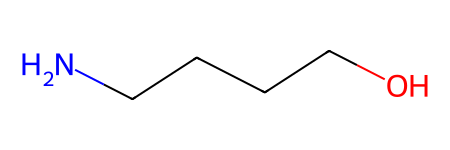

In [4]:
smi = 'O-C-C-C-C-N'
mol = Chem.MolFromSmiles(smi)
mol

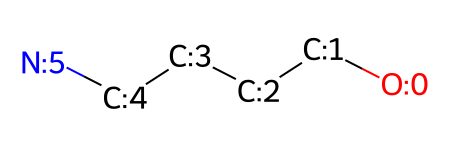

In [5]:
# Add atom indices to the molecule
for atom in mol.GetAtoms():
    atom.SetProp("atomLabel", atom.GetSymbol()+':'+str(atom.GetIdx()))
mol

In [6]:
for idx, bond in enumerate(mol.GetBonds()):
    print ("Bond Idx:", idx, "\t Begin:", bond .GetBeginAtomIdx(), "\t End:", bond.GetEndAtomIdx())

Bond Idx: 0 	 Begin: 0 	 End: 1
Bond Idx: 1 	 Begin: 1 	 End: 2
Bond Idx: 2 	 Begin: 2 	 End: 3
Bond Idx: 3 	 Begin: 3 	 End: 4
Bond Idx: 4 	 Begin: 4 	 End: 5


In [7]:
fragments = Chem.FragmentOnSomeBonds(mol, (0, 2, 4))
fragments

(<rdkit.Chem.rdchem.Mol at 0x150ca1198f20>,
 <rdkit.Chem.rdchem.Mol at 0x150ca1199000>)

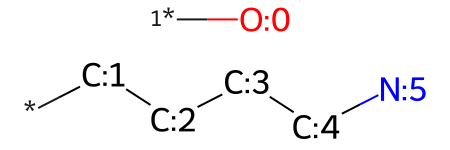

In [8]:
fragments[0]

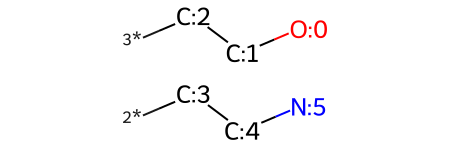

In [9]:
fragments[1]

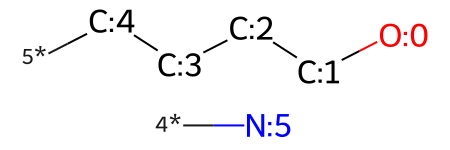

In [10]:
fragments[2]

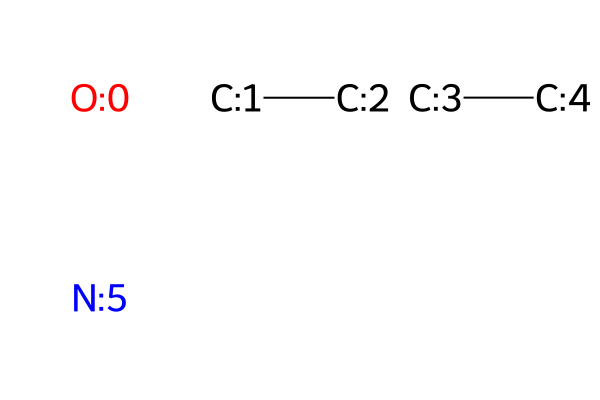

In [11]:
with Chem.RWMol(mol) as rwmol:
    for bond_idx in [0,2,4]:
        bond = rwmol.GetBondWithIdx(bond_idx)
        rwmol.RemoveBond(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())
Draw.MolsToGridImage(Chem.GetMolFrags(rwmol, asMols=True))

# BRICS fragmentation

In [12]:
from rdkit.Chem import BRICS

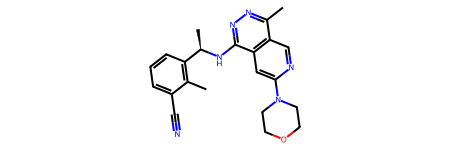

In [13]:
smi = 'C[C@H](C1=C(C(C#N)=CC=C1)C)NC2=NN=C(C)C3=C2C=C(N4CCOCC4)N=C3' # MRTX0902
mol = Chem.MolFromSmiles(smi)
mol

In [14]:
smi_fragments = list(Chem.BRICS.BRICSDecompose(mol))
smi_fragments

['[14*]c1cc2c([14*])nnc(C)c2cn1',
 '[16*]c1cccc(C#N)c1C',
 '[5*]N1CCOCC1',
 '[4*][C@@H]([8*])C',
 '[5*]N[5*]']

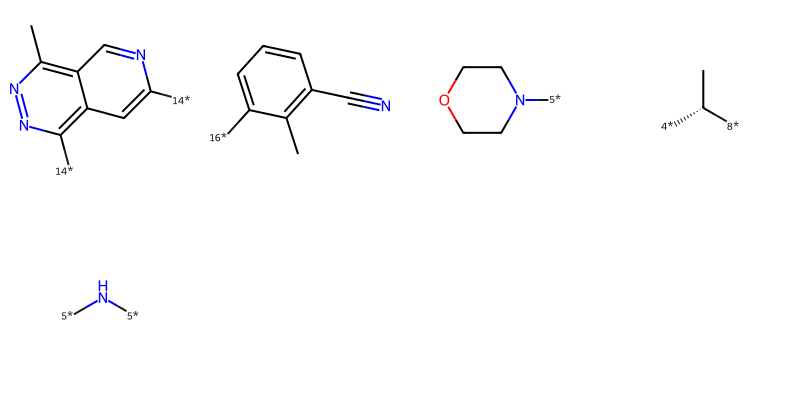

In [15]:
mol_fragments = [Chem.MolFromSmiles(smi) for smi in smi_fragments]
Draw.MolsToGridImage(mol_fragments, molsPerRow=4)

Is it enough?

# pBRICS fragmentation

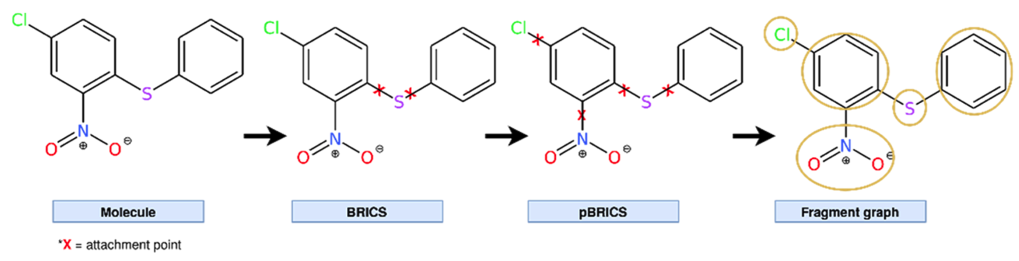

In [16]:
from IPython.display import Image
Image('pBRICS.png')

How can we implement pBRICS? 

In [17]:
from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol
from rdkit.Chem.BRICS import FindBRICSBonds

In [18]:
def mol_with_atom_index(mol):
    atoms = mol.GetNumAtoms()
    for idx in range(atoms):
        mol.GetAtomWithIdx(idx).SetProp('molAtomMapNumber', str(mol.GetAtomWithIdx(idx).GetIdx()))
    return mol

In [19]:
def get_linker_bond_list(mol):
    scaffold = GetScaffoldForMol(mol)
    atom_idx_in_scaffold = set(mol.GetSubstructMatch(scaffold))

    bond_list = mol.GetBonds()
    linker_bond_list = []
    for bond in bond_list:
        begin_, end_ = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        if (begin_ in atom_idx_in_scaffold) and (end_ in atom_idx_in_scaffold):
            pass
        else:
            if (begin_ in atom_idx_in_scaffold) or (end_ in atom_idx_in_scaffold):
                linker_bond_list.append(bond.GetIdx())
    return linker_bond_list

In [20]:
def get_brics_bond_list(mol):
    brics_results = list(FindBRICSBonds(mol))
    bond_list = [sorted(list(result[0])) for result in brics_results]

    bonds_to_break = []
    for bond in mol.GetBonds():
        begin_end_ = sorted([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
        if begin_end_ in bond_list:
            bonds_to_break.append(bond.GetIdx())
    return bonds_to_break

In [21]:
def get_fragments(
        mol,
        bonds_to_break,
    ):
    mol_fragments = []
    smi_fragments = []
    if len(bonds_to_break) > 0:
        results = Chem.FragmentOnBonds(mol, set(bonds_to_break), addDummies=True)
        mol_fragments = Chem.GetMolFrags(results, asMols=True)
        smi_fragments = [Chem.MolToSmiles(mol) for mol in mol_fragments]
    else:
        mol_fragments = [mol]
        smi_fragments = [Chem.MolToSmiles(mol)]
    return mol_fragments, smi_fragments

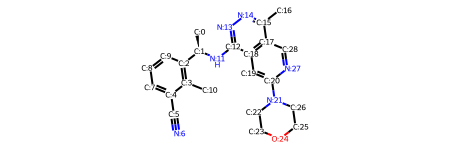

In [22]:
smi ='C[C@H](C1=C(C(C#N)=CC=C1)C)NC2=NN=C(C)C3=C2C=C(N4CCOCC4)N=C3' # MRTX0902
mol = Chem.MolFromSmiles(smi)
mol = mol_with_atom_index(mol)
mol

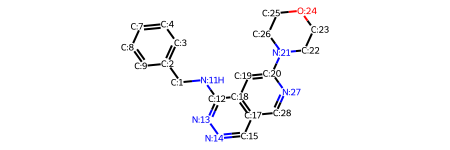

In [23]:
scaffold = GetScaffoldForMol(mol)
scaffold

In [24]:
linker_bond_list = get_linker_bond_list(mol)
for bond_idx in linker_bond_list:
    bond = mol.GetBondWithIdx(bond_idx)
    print ("Bond Idx:", bond_idx, "\t Begin:", bond.GetBeginAtomIdx(), "\t End:", bond.GetEndAtomIdx())

Bond Idx: 0 	 Begin: 0 	 End: 1
Bond Idx: 4 	 Begin: 4 	 End: 5
Bond Idx: 9 	 Begin: 3 	 End: 10
Bond Idx: 15 	 Begin: 15 	 End: 16


In [25]:
brics_bond_list = get_brics_bond_list(mol)
for bond_idx in brics_bond_list:
    bond = mol.GetBondWithIdx(bond_idx)
    print ("Bond Idx:", bond_idx, "\t Begin:", bond.GetBeginAtomIdx(), "\t End:", bond.GetEndAtomIdx())

Bond Idx: 1 	 Begin: 1 	 End: 2
Bond Idx: 10 	 Begin: 1 	 End: 11
Bond Idx: 11 	 Begin: 11 	 End: 12
Bond Idx: 20 	 Begin: 20 	 End: 21


In [26]:
bonds_to_break = sorted(linker_bond_list + brics_bond_list)
bonds_to_break

[0, 1, 4, 9, 10, 11, 15, 20]

In [27]:
mol_fragments, smi_fragments = get_fragments(
    mol=mol,
    bonds_to_break=bonds_to_break,
)

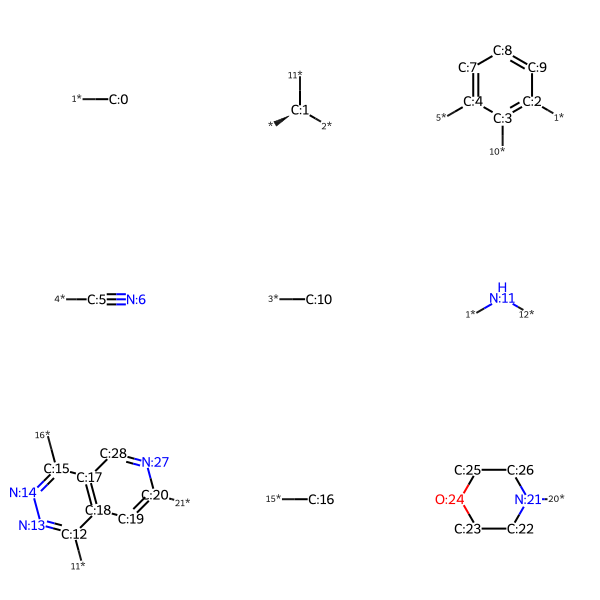

In [28]:
Draw.MolsToGridImage(mol_fragments)

I refer to "pBRICS: A Novel Fragmentation Method for Explainable Property Prediction of Drug-Like Small Molecules" for more details on algorithm and applications utilizing pBRICS fragmentation.
https://pubs.acs.org/doi/abs/10.1021/acs.jcim.3c00689

# Side-chain decoration (enumeration)

In [29]:
def add_groups(m, group):
    while True:
        # Find wildcard atom if available, otherwise exit
        a = None
        for a_ in m.GetAtoms():
            if a_.GetAtomicNum() == 0:
                a = a_
                break
        if a is None:
            break

        if group.GetNumAtoms() == 1:
            # Directly substitute atom in, if single atom group
            a.SetAtomicNum(group.GetAtomWithIdx(0).GetAtomicNum())
            a.SetAtomMapNum(0)
        else:
            # Set wildcard atoms to having AtomMapNum 1000 for tracking
            a.SetAtomMapNum(1000)

            for a_ in group.GetAtoms():
                if a_.GetAtomicNum() == 0:
                    a_.SetAtomMapNum(1000)

            # Put group and base molecule together and make it editable
            m = Chem.CombineMols(m, group)
            m = Chem.RWMol(m)

            # Find using tracking number the atoms to merge in new molecule
            a1 = None
            a2 = None
            bonds = []
            for a in m.GetAtoms():
                if a.GetAtomMapNum() == 1000:
                    if a1 is None:
                        a1 = a
                    else:
                        a2 = a

            # Find atoms to bind together based on atoms to merge
            b1 = a1.GetBonds()[0]
            start = (b1.GetBeginAtomIdx() if b1.GetEndAtomIdx() == a1.GetIdx()
                else b1.GetEndAtomIdx())

            b2 = a2.GetBonds()[0]
            end = (b2.GetBeginAtomIdx() if b2.GetEndAtomIdx() == a2.GetIdx()
                else b2.GetEndAtomIdx())

            # Add the connection and remove original wildcard atoms
            m.AddBond(start, end, order=Chem.rdchem.BondType.SINGLE)
            m.RemoveAtom(a1.GetIdx())
            m.RemoveAtom(a2.GetIdx())
    return m

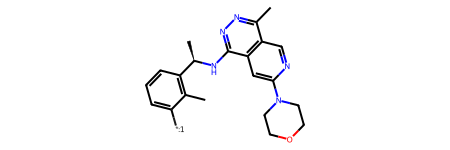

In [30]:
smi_core ='C[C@H](C1=C(C([*:1])=CC=C1)C)NC2=NN=C(C)C3=C2C=C(N4CCOCC4)N=C3' # MRTX0902
mol_core = Chem.MolFromSmiles(smi_core)
mol_core

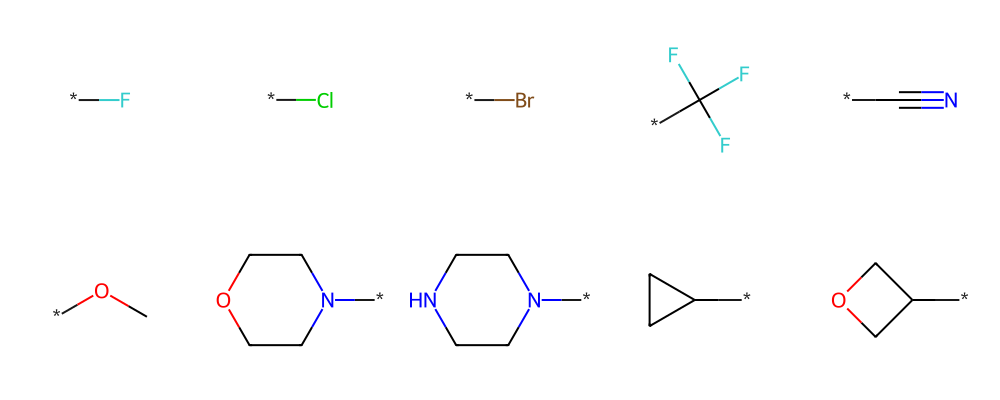

In [31]:
smi_substituents = [
    '[*]F', '[*]Cl', '[*]Br', '[*]C(F)(F)F', '[*]C#N', 
    '[*]OC', '[*]N1CCOCC1', '[*]N1CCNCC1', '[*]C1CC1', '[*]C1COC1',
]
mol_substituents = [Chem.MolFromSmiles(smi) for smi in smi_substituents]
Draw.MolsToGridImage(mol_substituents, molsPerRow=5)

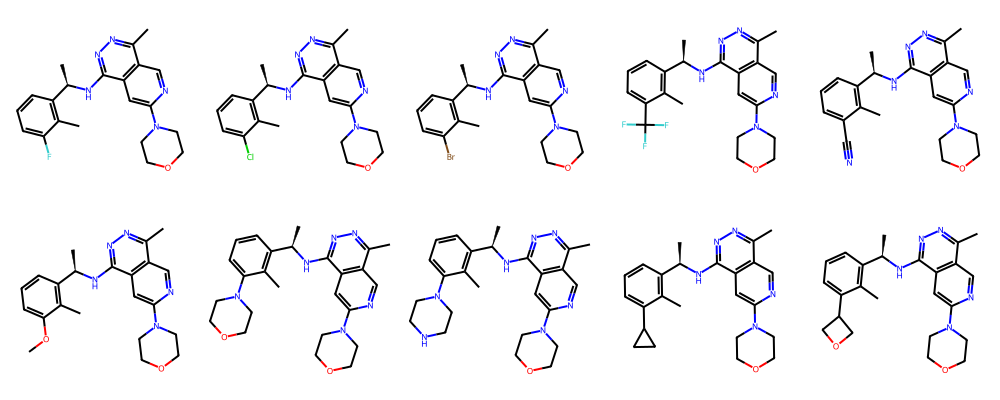

In [32]:
mol_substituted = [add_groups(mol_core, group) for group in mol_substituents]
Draw.MolsToGridImage(mol_substituted, molsPerRow=5)

# 3D-conformer generation

In [33]:
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_3d = True
import py3Dmol

from rdkit.Chem import rdDepictor
from rdkit.Chem import rdDistGeom

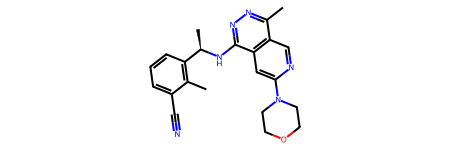

In [34]:
smi = 'C[C@H](C1=C(C(C#N)=CC=C1)C)NC2=NN=C(C)C3=C2C=C(N4CCOCC4)N=C3' # MRTX0902
mol = Chem.MolFromSmiles(smi)
mol

In [35]:
mol.GetNumConformers()

0

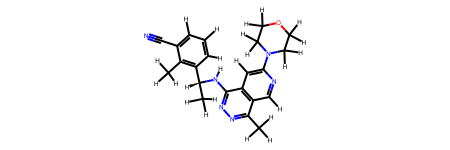

In [36]:
mol = Chem.AddHs(mol)
mol

In [37]:
rdDistGeom.EmbedMolecule(mol)

0

In [38]:
print(mol.GetNumConformers(), mol.GetConformer().Is3D())

1 True


In [39]:
rdDistGeom.EmbedMultipleConfs(mol, 10, randomSeed=0xf00d) # <- generate 10 conformers
print(mol.GetNumConformers(), mol.GetConformer().Is3D())

10 True


In [40]:
IPythonConsole.drawMol3D(mol)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

I refer to https://greglandrum.github.io/rdkit-blog/posts/2023-02-04-working-with-conformers.html for more practices on 3D conformer handling